In [1]:
import os
import re
import string

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [134]:
print("# File Size:")
for f in os.listdir('archive/'):
    if 'csv' in f:
        print(f.ljust(30) + str(round(os.path.getsize('archive/' + f) / 1000000, 2)) + 'MB')

# File Size:
app_events.csv                1037.27MB
app_labels.csv                11.19MB
brand_translate.csv           0.0MB
events.csv                    195.43MB
gender_age_test.csv           2.28MB
gender_age_train.csv          2.37MB
label_categories.csv          0.02MB
phone_brand_device_model.csv  6.72MB


# DEVICE

In [2]:
device = pd.read_csv('archive/phone_brand_device_model.csv')

In [3]:
# Check for duplicated device ID's
device.device_id.duplicated().value_counts()

False    186716
True        529
Name: device_id, dtype: int64

In [5]:
# Drop duplicates except for the first occurance from column 'device_id'
device = device.drop_duplicates(subset='device_id', keep='first')

In [6]:
# Data is in Chinese
device.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


## Translate Chinese to English

#### Prepare data for translation

In [7]:
device = device.rename(columns={'phone_brand' : 'device_brand'})

In [9]:
device.device_brand = device.device_brand.str.lower()

#### Translate

In [10]:
brands = pd.read_csv("archive/brand_translate.csv")

In [11]:
k = brands.chinese.tolist()
v = brands.english.tolist()
translate = dict(zip(k,v))

In [12]:
device = device.replace({"device_brand": translate,"device_model": translate})

In [13]:
device.head()

,device_id,device_brand,device_model
0,-8890648629457979026,xiaomi,red rice
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,sugar,fashion mobile phone
4,-5019277647504317457,samsung,Galaxy Note 2


# USER PROFILE

In [14]:
usr = pd.read_csv('archive/gender_age_train.csv')

In [15]:
# Sort DataFrame based on age
usr = usr.sort_values(by='age')
usr.head()

,device_id,gender,age,group
10385,3553057874282315257,M,1,M22-
60833,5222152119137955379,M,6,M22-
60832,3646841514566479686,M,6,M22-
60779,-8513863533705424532,M,6,M22-
60831,-5323874218045578676,M,6,M22-


In [16]:
# Delete group column because of inaccuracies
del usr['group']

In [17]:
# Filter DataFrame by age 15 and older
usr = usr[usr['age'] >= 15]

In [18]:
usr.head()

,device_id,gender,age
9485,9092359541057623393,M,15
9486,1951165708543290906,M,15
54142,-2012685777987824934,M,15
67172,-5564578405026453052,M,15
65638,8950414999564025446,M,15


### Consumer Segmentation

#### M

In [19]:
# Males age 15-24
male_segment_one = usr[(usr.gender == 'M') & (usr.age <= 24)]

In [20]:
male_segment_one = male_segment_one.assign(group = "M15-24")

In [21]:
# Males age 25-34
male_segment_two = usr[(usr.gender == 'M') & (usr.age >= 25) & (usr.age <= 34)]

In [22]:
male_segment_two= male_segment_two.assign(group = "M25-34")

In [23]:
# Males age 35-44
male_segment_three = usr[(usr.gender == 'M') & (usr.age >= 35) & (usr.age <= 44)]

In [24]:
male_segment_three = male_segment_three.assign(group = "M35-44")

In [25]:
# Males age 45 and older
male_segment_four = usr[(usr.gender == 'M') & (usr.age >= 45)]

In [26]:
male_segment_four = male_segment_four.assign(group = "M45+")

#### F

In [27]:
# Females age 15-24
female_segment_one = usr[(usr.gender == 'F') & (usr.age <= 24)]

In [28]:
female_segment_one = female_segment_one.assign(group = "F15-24")

In [29]:
# Females age 25-34
female_segment_two = usr[(usr.gender == 'F') & (usr.age >= 25) & (usr.age <= 34)]

In [30]:
female_segment_two = female_segment_two.assign(group = "F25-34")

In [31]:
# Females age 35-44
female_segment_three = usr[(usr.gender == 'F') & (usr.age >= 35) & (usr.age <= 44)]

In [32]:
female_segment_three = female_segment_three.assign(group = "F35-44")

In [33]:
# Females age 45 and older
female_segment_four = usr[(usr.gender == 'F') & (usr.age >= 45)]

In [34]:
female_segment_four = female_segment_four.assign(group = "F45+")

In [35]:
frames = [male_segment_one,male_segment_two, male_segment_three, male_segment_four,
         female_segment_one, female_segment_two, female_segment_three, female_segment_four]

In [36]:
usr = pd.concat(frames)

In [37]:
usr.head()

,device_id,gender,age,group
9485,9092359541057623393,M,15,M15-24
9486,1951165708543290906,M,15,M15-24
54142,-2012685777987824934,M,15,M15-24
67172,-5564578405026453052,M,15,M15-24
65638,8950414999564025446,M,15,M15-24


In [38]:
usr.shape

(74567, 4)

# EVENTS

In [2]:
events = pd.read_csv("archive/events.csv")

In [3]:
events['counts'] = events.groupby(['device_id'])['event_id'].transform('count')

In [4]:
events.head()

,event_id,device_id,timestamp,longitude,latitude,counts
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,256
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,73
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,248
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,47
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,525


In [41]:
events.event_id.duplicated().value_counts()

False    3252950
Name: event_id, dtype: int64

In [42]:
events.timestamp = pd.to_datetime(events.timestamp)

In [44]:
# events.sort_values('timestamp', inplace=True)

In [45]:
events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [46]:
events = events[(events.timestamp > '2016-04-30 23:59:59') & (events.timestamp < '2016-05-08 00:00:00')]

In [47]:
events.timestamp.min()

Timestamp('2016-05-01 00:00:00')

In [48]:
events.timestamp.max()

Timestamp('2016-05-07 23:59:50')

In [49]:
events["weekday"] = events["timestamp"].map(lambda x : x.weekday_name)

In [50]:
day = {'Sunday': 0,
       'Monday': 1,
       'Tuesday': 2,
       'Wednesday': 3,
       'Thursday': 4,
       'Friday': 5,
       'Saturday': 6}

events['day'] = events['weekday'].map(day)

In [51]:
events.head()

,event_id,device_id,timestamp,longitude,latitude,weekday,day
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,Sunday,0
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,Sunday,0
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,Sunday,0
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,Sunday,0
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,Sunday,0


In [52]:
events["hour"] = events["timestamp"].map(lambda x : x.hour)
events["minute"] = events["timestamp"].map(lambda x : x.minute)
events["second"] = events["timestamp"].map(lambda x : x.second)

In [53]:
events.head()

,event_id,device_id,timestamp,longitude,latitude,weekday,day,hour,minute,second
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,Sunday,0,0,55,25
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,Sunday,0,0,54,12
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,Sunday,0,0,8,5
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,Sunday,0,0,6,40
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,Sunday,0,0,7,18


In [54]:
events.event_id.duplicated().value_counts()

False    3251989
Name: event_id, dtype: int64

In [55]:
events.device_id.duplicated().value_counts()

True     3191124
False      60865
Name: device_id, dtype: int64

In [47]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim()

# APP CATEGORIES

In [63]:
categories = pd.read_csv("archive/label_categories.csv")

In [64]:
categories.head()

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


In [65]:
categories.isnull().sum()

label_id    0
category    3
dtype: int64

#### Replace 'NaN'

In [66]:
categories.category.fillna('unknown', inplace=True)

In [67]:
categories.isnull().sum()

label_id    0
category    0
dtype: int64

### 29 'unknown' in Category Column

In [70]:
unknown_category = categories.loc[categories['category'] == 'unknown']

In [71]:
unknown_category.shape

(29, 2)

In [73]:
# 'Unknown' category will stay in the DataFrame
categories.head()

,label_id,category
0,1,unknown
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


In [198]:
categories.label_id.duplicated().value_counts()

False    930
Name: label_id, dtype: int64

# APP LABELS

In [81]:
labels = pd.read_csv("archive/app_labels.csv")

In [82]:
labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [76]:
labels.shape

(459943, 2)

In [197]:
labels.label_id.duplicated().value_counts()

True     459436
False       507
Name: label_id, dtype: int64

## Map Categories to Lables

In [77]:
k = categories.label_id.tolist()
v = categories.category.tolist()
label_categories = dict(zip(k,v))

In [83]:
labels['app'] = labels['label_id'].map(label_categories)

In [84]:
applications = labels

In [85]:
applications.head()

,app_id,label_id,app
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,6058196446775239644,406,unknown
3,6058196446775239644,407,DS_P2P net loan
4,8694625920731541625,406,unknown


In [86]:
applications.shape

(459943, 3)

# APP EVENTS

In [92]:
app_events = pd.read_csv("archive/app_events.csv")

In [93]:
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [ ]:
app_events.event_id.duplicated().value_counts()

### Active App Events

In [94]:
active = app_events[app_events.is_active == 1]

#### 12,732,996 Active Events

In [95]:
active.shape

(12732996, 4)

In [96]:
active.shape

(12732996, 4)

## Map Applications to App Events

In [98]:
k = applications.app_id.tolist()
v = applications.app.tolist()
applications = dict(zip(k,v))

In [99]:
app_events['application'] = app_events['app_id'].map(applications)

In [100]:
app_events.head()

,event_id,app_id,is_installed,is_active,application
0,2,5927333115845830913,1,1,IM
1,2,-5720078949152207372,1,0,unknown
2,2,-1633887856876571208,1,0,P2P net loan
3,2,-653184325010919369,1,1,Consumer Finance
4,2,8693964245073640147,1,1,IM


In [101]:
app_events.shape

(32473067, 5)

# MERGE

In [102]:
df1 = usr.merge(device, on="device_id")

In [103]:
df2 = events

In [104]:
df3 = app_events

In [105]:
df2.event_id.duplicated().value_counts()

False    3251989
Name: event_id, dtype: int64

In [106]:
df3.event_id.duplicated().value_counts()

True     30984971
False     1488096
Name: event_id, dtype: int64

In [107]:
talkevents = df3.drop_duplicates(subset='event_id', keep='first')

In [108]:
talkevents.shape

(1488096, 5)

## Data Merge

In [109]:
data = df2.merge(df1, on="device_id")

In [116]:
data.shape

(1215124, 15)

In [110]:
data.head()

,event_id,device_id,timestamp,longitude,latitude,weekday,day,hour,minute,second,gender,age,group,device_brand,device_model
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,Sunday,0,0,55,25,M,46,M45+,xiaomi,红米note
1,7104,29182687948017175,2016-05-02 09:37:02,121.38,31.24,Monday,1,9,37,2,M,46,M45+,xiaomi,红米note
2,29661,29182687948017175,2016-05-04 00:56:04,121.39,31.23,Wednesday,3,0,56,4,M,46,M45+,xiaomi,红米note
3,33133,29182687948017175,2016-05-06 05:01:15,121.38,31.24,Friday,5,5,1,15,M,46,M45+,xiaomi,红米note
4,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,Friday,5,9,55,4,M,46,M45+,xiaomi,红米note


### Data Set 
(556150, 19)

In [113]:
# Dataframe with no duplicated events
dataframe = data.merge(talkevents, on="event_id")

In [112]:
dataframe.shape

(556150, 19)

In [114]:
dataframe.head()

,event_id,device_id,timestamp,longitude,latitude,weekday,day,hour,minute,second,gender,age,group,device_brand,device_model,app_id,is_installed,is_active,application
0,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,Friday,5,9,55,4,M,46,M45+,xiaomi,红米note,6666573791286858743,1,1,P2P net loan
1,70894,29182687948017175,2016-05-06 01:14:46,121.38,31.24,Friday,5,1,14,46,M,46,M45+,xiaomi,红米note,4377590530406372538,1,1,P2P net loan
2,184478,29182687948017175,2016-05-05 19:14:09,0.00,0.00,Thursday,4,19,14,9,M,46,M45+,xiaomi,红米note,3300927412659348909,1,1,Industry tag
3,191673,29182687948017175,2016-05-01 05:24:36,121.38,31.24,Sunday,0,5,24,36,M,46,M45+,xiaomi,红米note,3300927412659348909,1,1,Industry tag
4,217601,29182687948017175,2016-05-03 06:55:14,0.00,0.00,Tuesday,2,6,55,14,M,46,M45+,xiaomi,红米note,6324195652631771565,1,1,Medical


In [165]:
# (556150, 19)
dataframe.to_csv('talkdata.csv')

### Larger Data Set
(12233082, 19)

In [119]:
df = df3.merge(data, on="event_id")

In [120]:
df.shape

(12233082, 19)

In [121]:
df.head()

,event_id,app_id,is_installed,is_active,application,device_id,timestamp,longitude,latitude,weekday,day,hour,minute,second,gender,age,group,device_brand,device_model
0,6,-7377004479023402858,1,1,map,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,Sunday,0,0,27,21,M,19,M15-24,huawei,Mate 7
1,6,6284164581582112235,1,1,Industry tag,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,Sunday,0,0,27,21,M,19,M15-24,huawei,Mate 7
2,6,5927333115845830913,1,1,IM,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,Sunday,0,0,27,21,M,19,M15-24,huawei,Mate 7
3,6,3433289601737013244,1,1,Property Industry 1.0,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,Sunday,0,0,27,21,M,19,M15-24,huawei,Mate 7
4,6,-3467200097934864127,1,1,Consumer Finance,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,Sunday,0,0,27,21,M,19,M15-24,huawei,Mate 7


In [125]:
# (12233082, 19)
df.to_csv('bigtalk.csv')

# CHINA

In [2]:
china = pd.read_csv('archive/china.csv')

In [5]:
dataframe = china

### China Data Set 

In [6]:
# DataSet 'talkdata.csv'
china = dataframe[(dataframe.longitude > 75) & (dataframe.longitude < 135) & (dataframe.latitude > 15) & (dataframe.latitude < 55)]

In [128]:
china.head()

,event_id,device_id,timestamp,longitude,latitude,weekday,day,hour,minute,second,gender,age,group,device_brand,device_model,app_id,is_installed,is_active,application
0,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,Friday,5,9,55,4,M,46,M45+,xiaomi,红米note,6666573791286858743,1,1,P2P net loan
1,70894,29182687948017175,2016-05-06 01:14:46,121.38,31.24,Friday,5,1,14,46,M,46,M45+,xiaomi,红米note,4377590530406372538,1,1,P2P net loan
3,191673,29182687948017175,2016-05-01 05:24:36,121.38,31.24,Sunday,0,5,24,36,M,46,M45+,xiaomi,红米note,3300927412659348909,1,1,Industry tag
5,273615,29182687948017175,2016-05-02 09:31:50,121.38,31.24,Monday,1,9,31,50,M,46,M45+,xiaomi,红米note,-7745076081943986520,1,1,online shopping navigation
6,292765,29182687948017175,2016-05-06 00:09:45,121.38,31.24,Friday,5,0,9,45,M,46,M45+,xiaomi,红米note,-7745076081943986520,1,0,online shopping navigation


In [130]:
china.to_csv('china.csv')

### Active in China

In [172]:
active_china = china.loc[china['is_active'] == 1]

In [173]:
active_china.shape

(127430, 19)

### China Talk Data Set

In [127]:
# Large DataSet 'bigtalk.csv' (12233082, 19)
chinatalk = df[(df.longitude > 75) & (df.longitude < 135) & (df.latitude > 15) & (df.latitude < 55)]

In [129]:
chinatalk.head()

,event_id,app_id,is_installed,is_active,application,device_id,timestamp,longitude,latitude,weekday,day,hour,minute,second,gender,age,group,device_brand,device_model
38,29,6284164581582112235,1,1,Industry tag,7166563712658305181,2016-05-01 00:31:40,117.96,28.47,Sunday,0,0,31,40,M,60,M45+,huawei,荣耀畅玩4C
39,29,5927333115845830913,1,0,IM,7166563712658305181,2016-05-01 00:31:40,117.96,28.47,Sunday,0,0,31,40,M,60,M45+,huawei,荣耀畅玩4C
40,29,3433289601737013244,1,1,Property Industry 1.0,7166563712658305181,2016-05-01 00:31:40,117.96,28.47,Sunday,0,0,31,40,M,60,M45+,huawei,荣耀畅玩4C
41,29,8693964245073640147,1,1,IM,7166563712658305181,2016-05-01 00:31:40,117.96,28.47,Sunday,0,0,31,40,M,60,M45+,huawei,荣耀畅玩4C
42,29,5786744307712698105,1,0,weibo,7166563712658305181,2016-05-01 00:31:40,117.96,28.47,Sunday,0,0,31,40,M,60,M45+,huawei,荣耀畅玩4C


## China

Total # China events: 193193


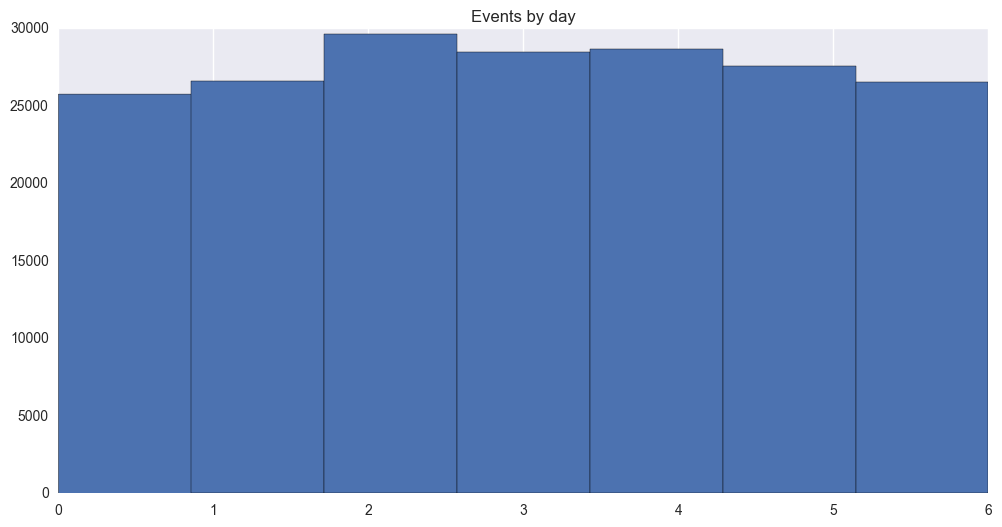

In [136]:
print("Total # China events:", len(china))

plt.figure(1, figsize=(12,6))
plt.title("Events by day")
plt.hist(china['day'], bins=7)
plt.show()

In [191]:
print("Total China Users: ", len(china))
print("\nChina User Group Counts:")
china["group"].value_counts().sort_values()

Total China Users:  193193

China User Group Counts:


F45+       6296
F15-24     8095
F35-44    10042
M45+      15514
F25-34    21867
M15-24    22407
M35-44    32218
M25-34    76754
Name: group, dtype: int64

In [192]:
print("Percentage of Male vs. Female")
china.gender.value_counts()/len(china)*100

Percentage of Male vs. Female


M    76.034328
F    23.965672
Name: gender, dtype: float64

M    146893
F     46300
Name: gender, dtype: int64


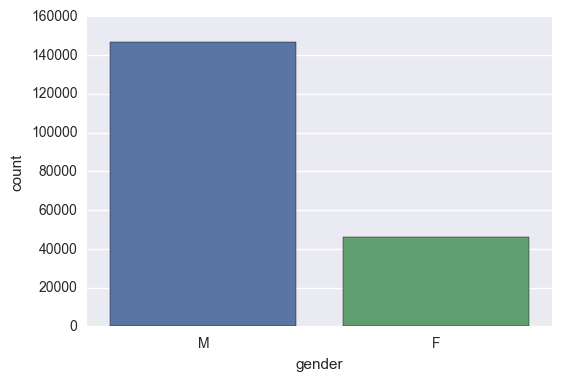

In [182]:
print(china.gender.value_counts())
ax = sns.countplot(data=china, x="gender")

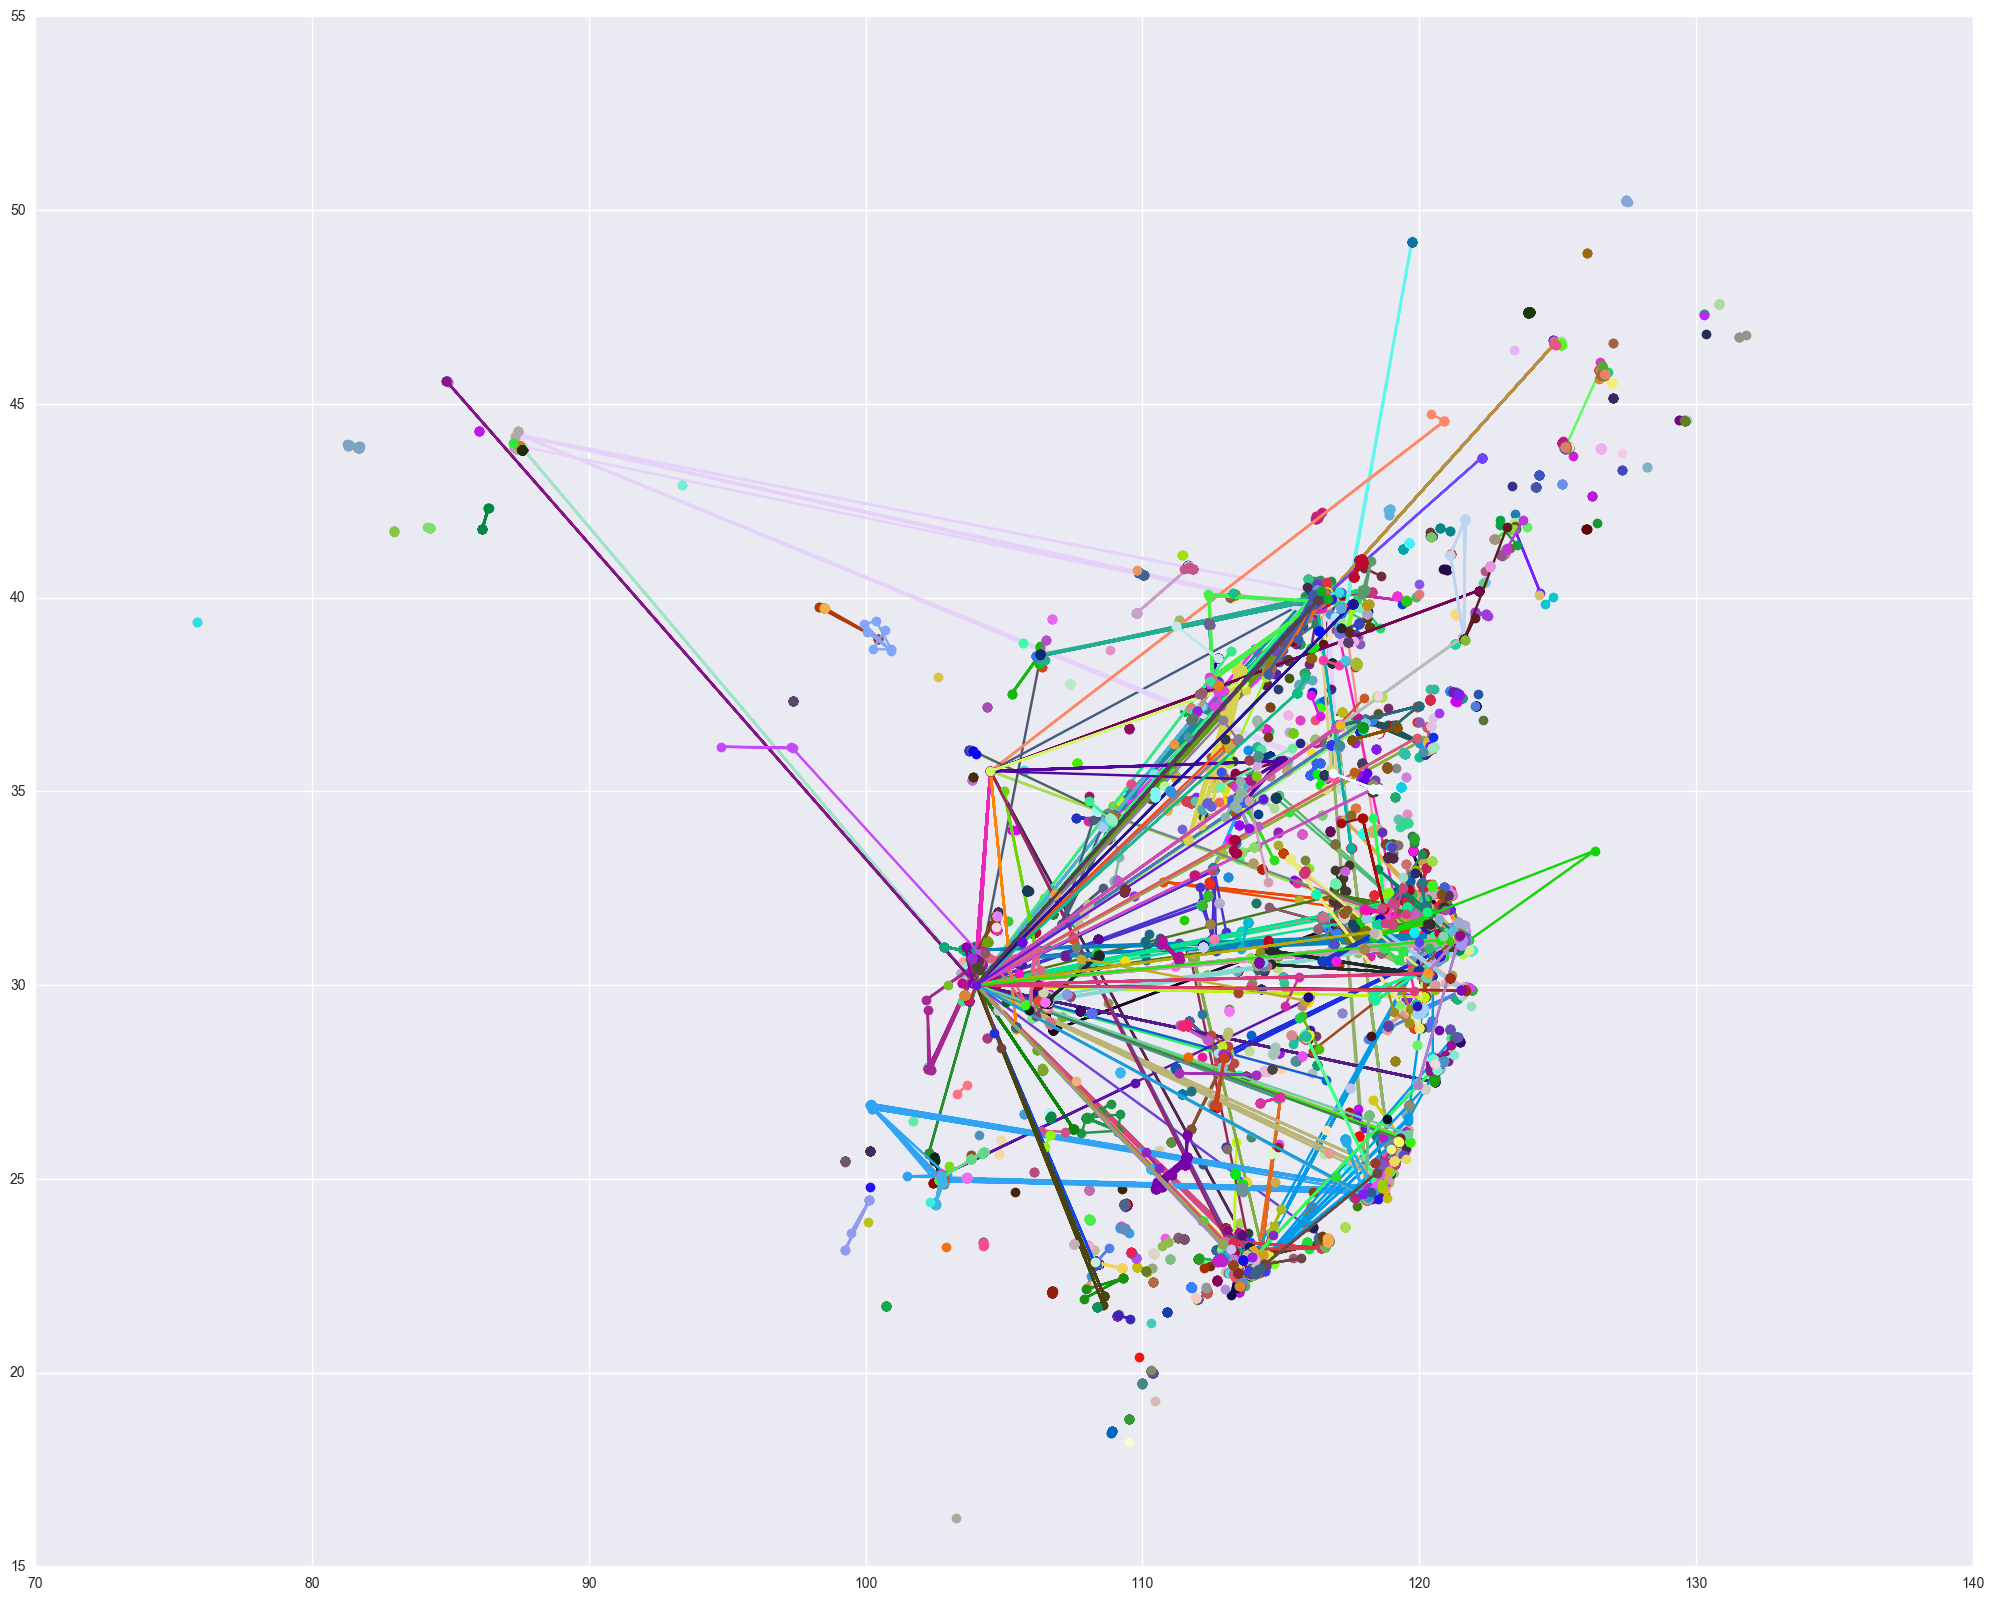

In [166]:
x = china
gd = x.groupby('device_id')

# Number of people to show
i = 2000

plt.figure(figsize=(25,20)) 
for g in gd:
    g = g[1]
    # Limit to china only
    g = g.loc[(g.latitude > 15) & (g.latitude < 55)]
    g = g.loc[(g.longitude > 75) & (g.longitude < 135)]
    lon = g['longitude']
    lat = g['latitude']
    plt.plot(lon, lat, '-o', color=np.random.rand(3).tolist())
    i -= 1
    if i < 0:
        break
    
plt.show()

## Beijing, China

In [137]:
beijing = dataframe[(dataframe.longitude > 116) & (dataframe.longitude < 117) & (dataframe.latitude > 39.5) & (dataframe.latitude < 40.5)]

Total # China events: 193193
Total # Beijing, China events: 11538


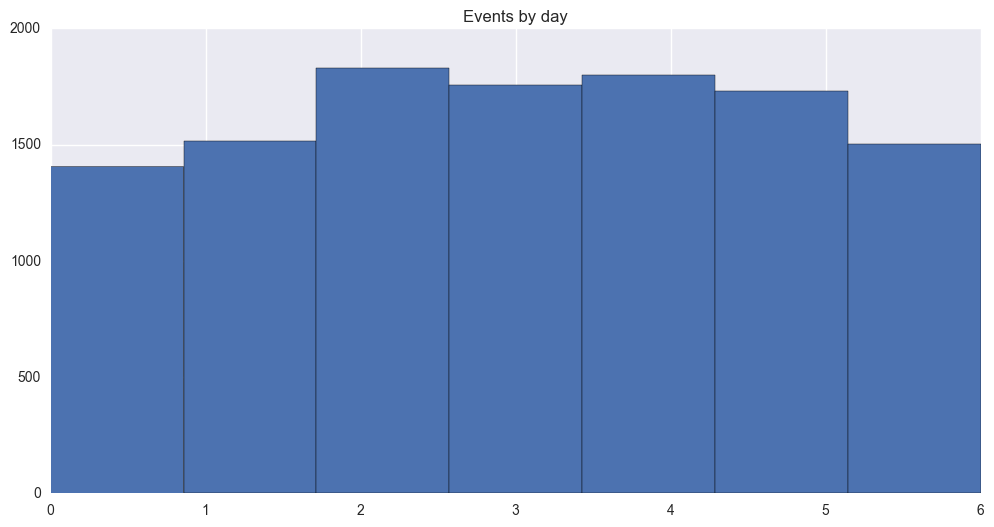

In [138]:
print("Total # China events:", len(china))
print("Total # Beijing, China events:", len(beijing))

plt.figure(1, figsize=(12,6))
plt.title("Events by day")
plt.hist(beijing['day'], bins=7)
plt.show()

In [ ]:
plt.figure(1, figsize=(12,6))
plt.title("Events by hour")


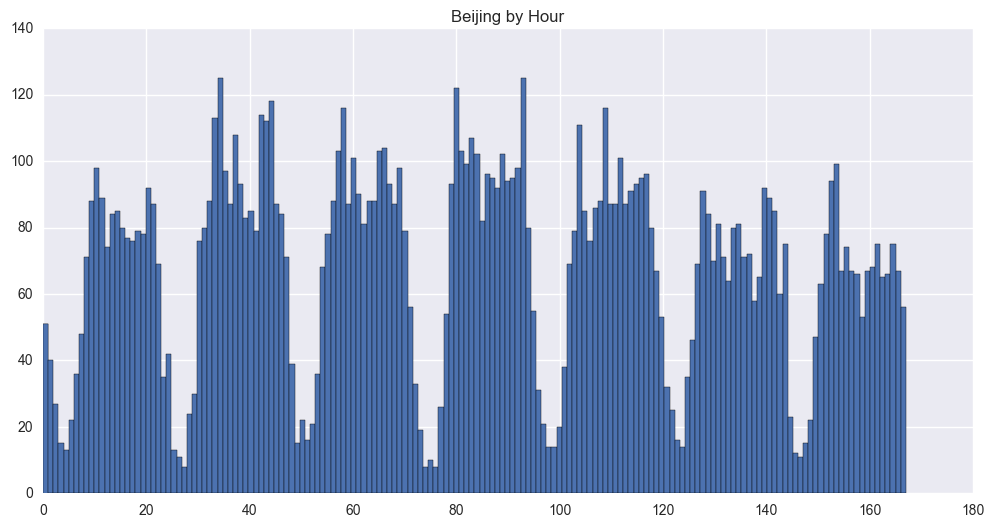

In [153]:
plt.figure(1, figsize=(12,6))
plt.title("Beijing by Hour")
plt.hist(beijing['timestamp'].map(lambda x: pd.to_datetime(x).dayofweek*24 + pd.to_datetime(x).hour), bins=168)
plt.show()

In [190]:
print("Total Beijing Users: ", len(beijing))
print("\nBeijing User Group Counts:")
beijing["group"].value_counts().sort_values()

Total Beijing Users:  11538

Beijing User Group Counts:


F15-24     309
F45+       457
F35-44     562
M15-24    1289
M45+      1325
F25-34    1634
M35-44    1784
M25-34    4178
Name: group, dtype: int64

M    8576
F    2962
Name: gender, dtype: int64


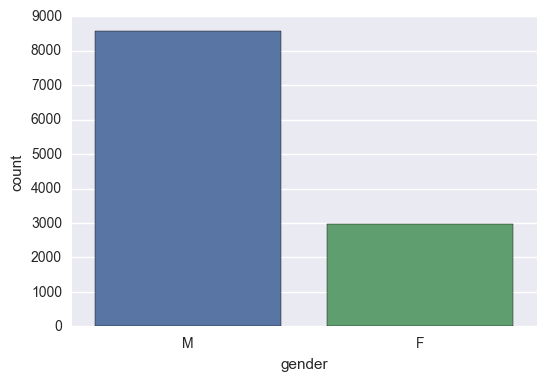

In [183]:
print(beijing.gender.value_counts())
ax = sns.countplot(data=beijing, x="gender")

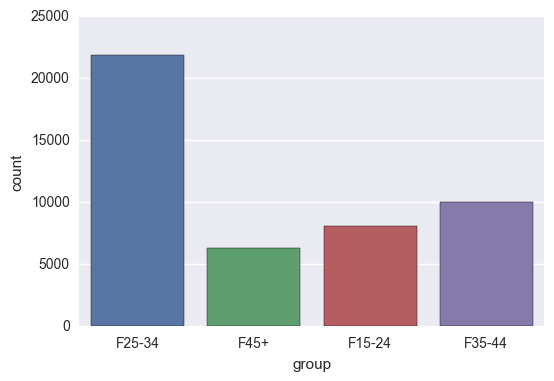

In [7]:
ax = sns.countplot(data=china[china.gender=="F"], x="group")

Men


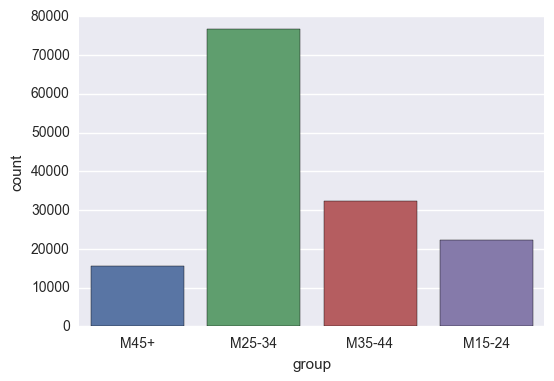

In [193]:
print("Men")
ax = sns.countplot(data=china[china.gender=="M"], x="group")

## Chengdu, China

In [174]:
chengdu = dataframe[(dataframe.longitude > 103.5) & (dataframe.longitude < 104.5) & (dataframe.latitude > 30) & (dataframe.latitude < 31)]

Total # China events: 193193
Total # Chengdu, China events: 7065


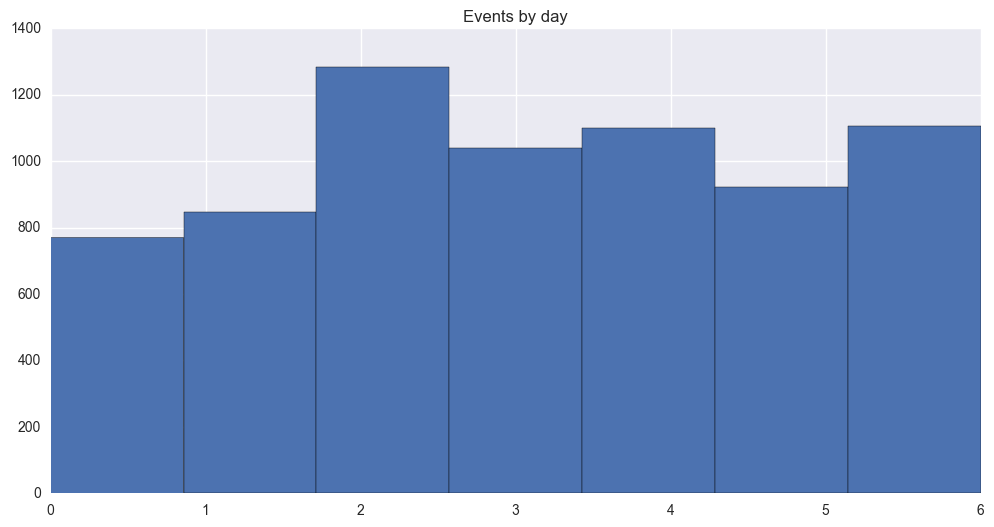

In [175]:
print("Total # China events:", len(china))
print("Total # Chengdu, China events:", len(chengdu))

plt.figure(1, figsize=(12,6))
plt.title("Events by day")
plt.hist(chengdu['day'], bins=7)
plt.show()

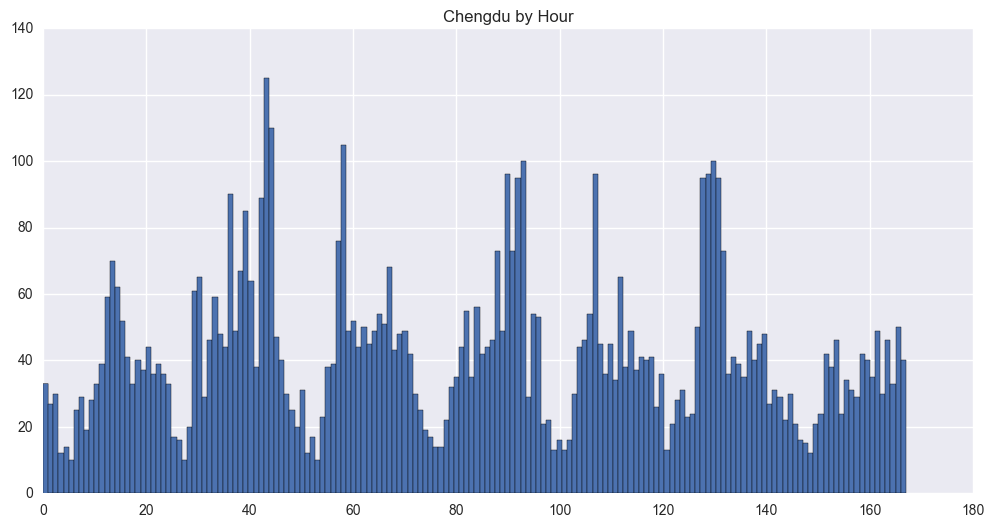

In [176]:
plt.figure(1, figsize=(12,6))
plt.title("Chengdu by Hour")
plt.hist(chengdu['timestamp'].map(lambda x: pd.to_datetime(x).dayofweek*24 + pd.to_datetime(x).hour), bins=168)
plt.show()

In [189]:
print("Total Chengdu Users: ", len(chengdu))
print("\nChengdu User Group Counts:")
chengdu["group"].value_counts().sort_values()

Total Chengdu Users:  7065

Chengdu User Group Counts:


F45+        30
F35-44     129
M45+       463
M15-24     783
F25-34     836
M35-44     864
F15-24    1224
M25-34    2736
Name: group, dtype: int64

M    4846
F    2219
Name: gender, dtype: int64


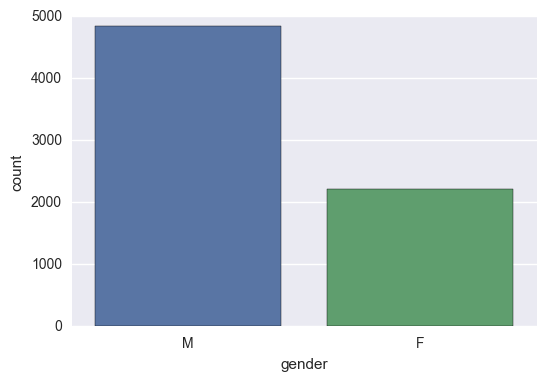

In [184]:
print(chengdu.gender.value_counts())
ax = sns.countplot(data=chengdu, x="gender")

# Shanghai, China

In [178]:
shanghai = dataframe[(dataframe.longitude > 121) & (dataframe.longitude < 122) & (dataframe.latitude > 31) & (dataframe.latitude < 32)]

Total # China events: 193193
Total # Shanghai, China events: 7405


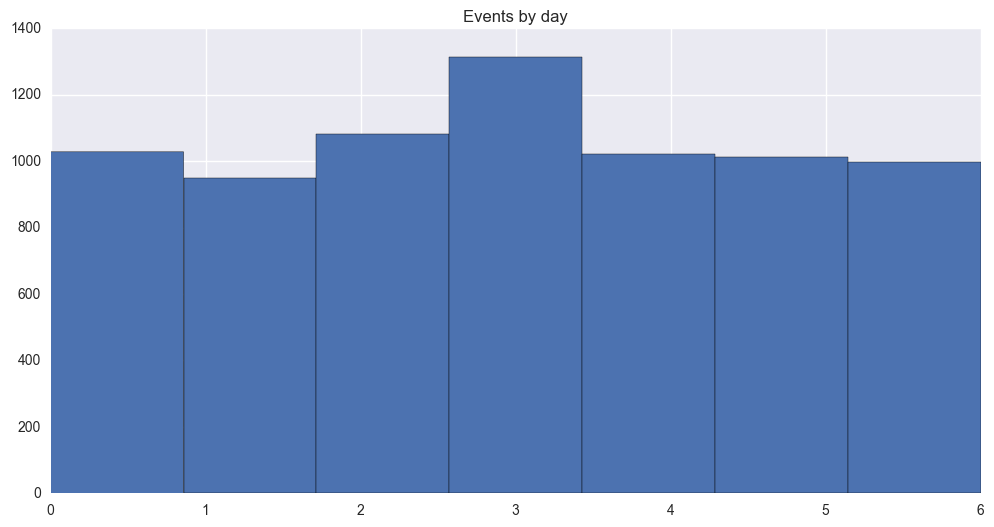

In [179]:
print("Total # China events:", len(china))
print("Total # Shanghai, China events:", len(shanghai))

plt.figure(1, figsize=(12,6))
plt.title("Events by day")
plt.hist(shanghai['day'], bins=7)
plt.show()

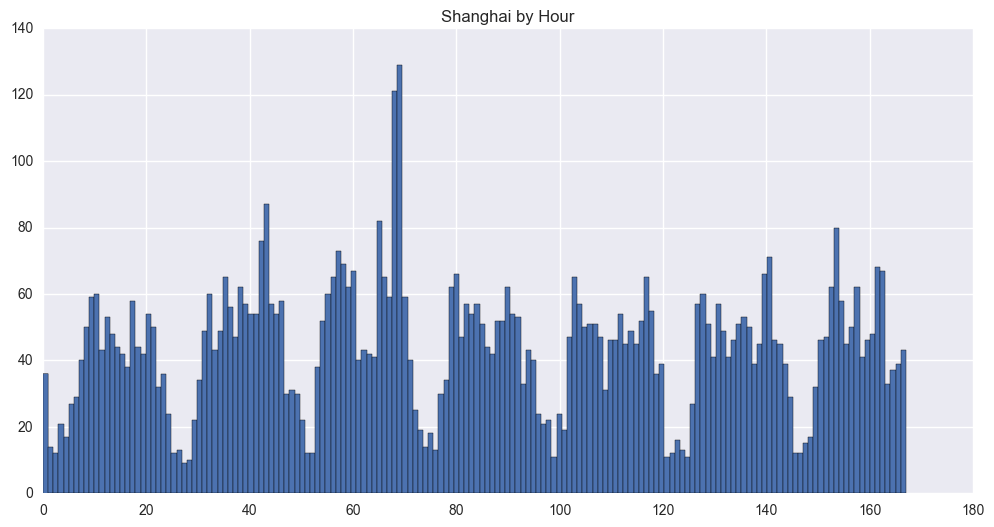

In [180]:
plt.figure(1, figsize=(12,6))
plt.title("Shanghai by Hour")
plt.hist(shanghai['timestamp'].map(lambda x: pd.to_datetime(x).dayofweek*24 + pd.to_datetime(x).hour), bins=168)
plt.show()

In [188]:
print("Total Shanghai Users: ", len(shanghai))
print("\nShanghai User Group Counts:")
shanghai["group"].value_counts().sort_values()

Total Shanghai Users:  7405

Shanghai User Group Counts:


F15-24     142
F35-44     191
F45+       198
M15-24     452
F25-34     749
M35-44    1241
M45+      1397
M25-34    3035
Name: group, dtype: int64

M    6125
F    1280
Name: gender, dtype: int64


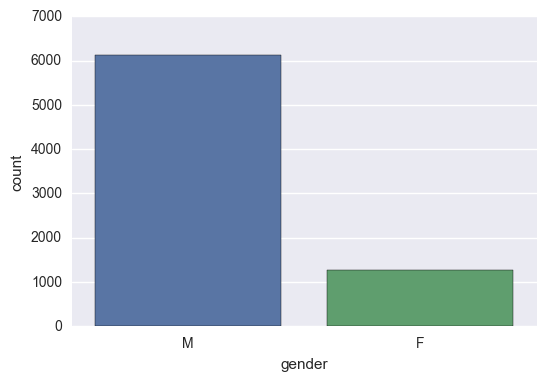

In [185]:
print(shanghai.gender.value_counts())
ax = sns.countplot(data=shanghai, x="gender")

# Hong Kong, China

In [143]:
hongkong = dataframe[(dataframe.longitude > 114) & (dataframe.longitude < 115) & (dataframe.latitude > 22) & (dataframe.latitude < 23)]

Total # China events: 193193
Total # Hong Kong, China events: 4970


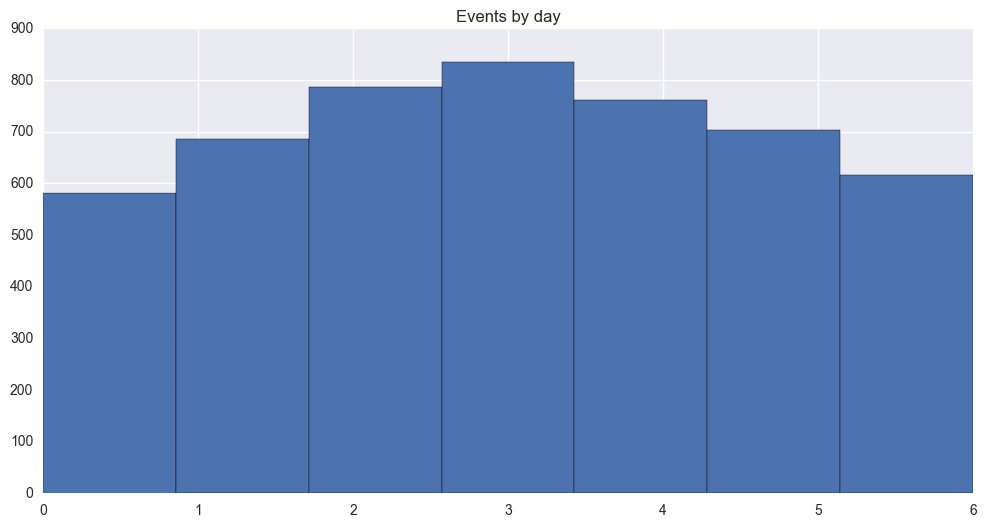

In [144]:
print("Total # China events:", len(china))
print("Total # Hong Kong, China events:", len(hongkong))

plt.figure(1, figsize=(12,6))
plt.title("Events by day")
plt.hist(hongkong['day'], bins=7)
plt.show()

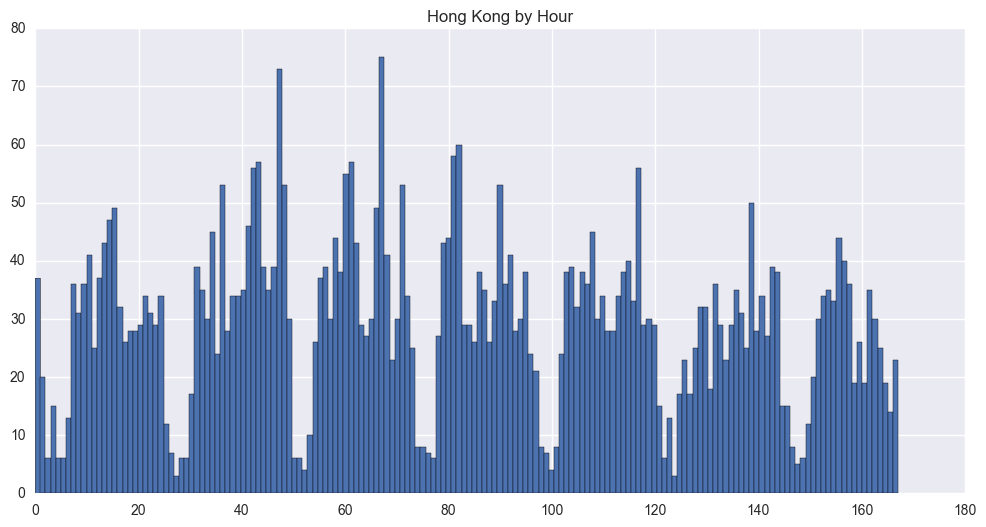

In [156]:
plt.figure(1, figsize=(12,6))
plt.title("Hong Kong by Hour")
plt.hist(hongkong['timestamp'].map(lambda x: pd.to_datetime(x).dayofweek*24 + pd.to_datetime(x).hour), bins=168)
plt.show()

In [187]:
print("Total Hong Kong Users: ", len(hongkong))
print("\nHong Kong User Group Counts:")
hongkong["group"].value_counts().sort_values()

Total Hong Kong Users:  4970

Hong Kong User Group Counts:


F35-44      32
F15-24      60
F45+       133
M15-24     600
F25-34     615
M45+       672
M35-44     773
M25-34    2085
Name: group, dtype: int64

M    4130
F     840
Name: gender, dtype: int64


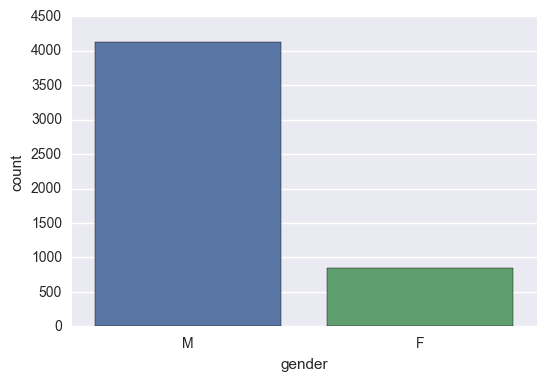

In [186]:
print(hongkong.gender.value_counts())
ax = sns.countplot(data=hongkong, x="gender")

In [195]:
test = pd.read_csv('archive/gender_age_test.csv')

In [196]:
test.head()

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [199]:
talkdata = dataframe

In [202]:
talkdata.head()

,event_id,device_id,timestamp,longitude,latitude,weekday,day,hour,minute,second,gender,age,group,device_brand,device_model,app_id,is_installed,is_active,application
0,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,Friday,5,9,55,4,M,46,M45+,xiaomi,红米note,6666573791286858743,1,1,P2P net loan
1,70894,29182687948017175,2016-05-06 01:14:46,121.38,31.24,Friday,5,1,14,46,M,46,M45+,xiaomi,红米note,4377590530406372538,1,1,P2P net loan
2,184478,29182687948017175,2016-05-05 19:14:09,0.00,0.00,Thursday,4,19,14,9,M,46,M45+,xiaomi,红米note,3300927412659348909,1,1,Industry tag
3,191673,29182687948017175,2016-05-01 05:24:36,121.38,31.24,Sunday,0,5,24,36,M,46,M45+,xiaomi,红米note,3300927412659348909,1,1,Industry tag
4,217601,29182687948017175,2016-05-03 06:55:14,0.00,0.00,Tuesday,2,6,55,14,M,46,M45+,xiaomi,红米note,6324195652631771565,1,1,Medical


In [203]:
talkdata.shape

(556150, 19)